In [1]:
import pandas as pd
import gspread
import copy
import matplotlib.pyplot as plt
from oauth2client.service_account import ServiceAccountCredentials

# glibber glabber that I copied and pasted
scope = ['https://spreadsheets.google.com/feeds']
credentials = ServiceAccountCredentials.from_json_keyfile_name('practice-log-444917-d375b6889398.json', scope)
gc = gspread.authorize(credentials)

# spreadsheet_key = '1AgQWFFgXEYRAtokWU8NNDdGKy5R7DYBoPMFukrRtMiA' # This is the test sheet
spreadsheet_key = '13CdEbddbIDDHdCVU9IvpHQzSB4lJroJ36Riufl5uvTk' # This is the real sheet
book = gc.open_by_key(spreadsheet_key)

In [2]:
# Studio in order of grade then alphabetical by last name
studio_names = ['Jaime Cardenas', 'Anna Desfore', 'Matt Schneider', 'Tanner Day', 'Trevor Maliborski', 'Adina Shaikh', 'Dylan Chapman', 'Joshua Dieter',
          'Van Maxwell', 'Cadie Strahota', 'Nate Dreyfus', 'Ravlin Frantz', 'Ellis Goeden', 'Kendal Schreiber', 'Alex Seitler',
          'Cooper Atkinson', 'Aaron Dieter', 'Ryan Gomez', 'Annabelle Nault', 'Marley Van Domelan','Eleanor Peska', 'Aidan Lishner', 'Pete Navratil', 'Nick Ruplinger']

In [3]:
# database of names and nicknames

names = {}
# add first names to database
for full_name in studio_names:
    first_name = full_name.split(' ')[0].lower()
    names[full_name] = [first_name]

names['Cooper Atkinson'].append('coop')
names['Ravlin Frantz'].append('rav')
names['Joshua Dieter'].append('josh')

In [4]:
# grade by name

name_grade = {}

# DMA
for name in ['Jaime Cardenas', 'Anna Desfore', 'Matt Schneider']:
    name_grade[name] = 'DMA'

# Master
for name in ['Tanner Day']:
    name_grade[name] = 'Masters'

# Super Senior
for name in ['Trevor Maliborski', 'Adina Shaikh']:
    name_grade[name] = 'Super Senior'

# Senior
for name in ['Dylan Chapman', 'Joshua Dieter', 'Van Maxwell', 'Cadie Strahota']:
    name_grade[name] = 'Senior'
    
# Junior
for name in ['Nate Dreyfus', 'Ravlin Frantz', 'Ellis Goeden', 'Kendal Schreiber', 'Alex Seitler']:
    name_grade[name] = 'Junior'

# Sophomore
for name in ['Cooper Atkinson', 'Aaron Dieter', 'Ryan Gomez', 'Annabelle Nault', 'Marley Van Domelan', 'Eleanor Peska']:
    name_grade[name] = 'Sophomore'

# Freshman
for name in ['Aidan Lishner', 'Pete Navratil', 'Nick Ruplinger']:
    name_grade[name] = 'Freshman'

In [5]:
timeframes = ['7:00 AM','7:15 AM','7:30 AM','7:45 AM','8:00 AM','8:15 AM','8:30 AM','8:45 AM','9:00 AM','9:15 AM','9:30 AM','9:45 AM', 
'10:00 AM','10:15 AM','10:30 AM','10:45 AM','11:00 AM','11:15 AM','11:30 AM','11:45 AM','12:00 PM','12:15 PM','12:30 PM','12:45 PM','1:00 PM', \
'1:15 PM','1:30 PM','1:45 PM','2:00 PM','2:15 PM','2:30 PM','2:45 PM','3:00 PM','3:15 PM','3:30 PM','3:45 PM','4:00 PM','4:15 PM','4:30 PM','4:45 PM', \
'5:00 PM','5:15 PM','5:30 PM','5:45 PM','6:00 PM','6:15 PM','6:30 PM','6:45 PM','7:00 PM','7:15 PM','7:30 PM','7:45 PM','8:00 PM','8:15 PM','8:30 PM', \
'8:45 PM','9:00 PM','9:15 PM','9:30 PM','9:45 PM','10:00 PM','10:15 PM','10:30 PM','10:45 PM']

In [6]:
# function to determine if a name is in the studio, returns full name or name that was inputted
def name_grabber(cell):
    name = None
    for full_name, names_list in names.items():
        for curr_name in names_list:
            if curr_name == cell:
                name = full_name
        if name != None:
            break
    if name == None:
        return cell
    else:
        return name

In [7]:
# full_df
# takes str room and int week_num and returns the str room_week and a df with filled in gaps
def full_df(room, week_num):
    room_week = (room + " (" + str(week_num) + ")") 
    worksheet = book.worksheet(room_week)
    table = worksheet.get_all_values() # fetch values from worksheet
    
    # Format Table in Pandas
    # Time      Mon   Tue ...
    # 7:00 AM   Josh   '' ...
    # 7:15 AM   Josh   '' ...
    # ...
    df = pd.DataFrame(table[3:67])
    df.columns = ['Time', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    
    for day in df:
        series = df[day]
        for idx in range(len(series)):
            cell = series.iloc[idx]
            if cell != '':   # "if cell is not empty..."
                diff = 1
                for count in range(1,9):
                    if (idx + count) > (len(series) - 1):   # max bounds case
                        break
                    next_cell = series.iloc[idx + count]
                    if (next_cell != cell) and (next_cell != ''):
                        break
                    if next_cell == cell:
                        diff = count
                        break
                for i in range(diff):
                    df.loc[i + idx, day] = cell
                    
    df = df.set_index('Time').rename_axis(None)
    return room_week, df

In [8]:
# rooms
rooms = ["Studio", "1401", "1407", "1409", "1413", "1414", "1416", "1417", "1418"]

In [9]:
# compile dataframes, don't run too much or will overload page
compiled_data = {}
for room in rooms:
    for week_num in range(1,3):
        room_week, df = full_df(room, week_num)
        compiled_data[room_week] = df
# compiled_data

In [10]:
# summarizing the data

entries_by_person = {}
other_entries = []
entries_by_person_by_time = {}
entries_by_time = {}

entries_by_room = {}
entries_by_person_by_room = {}
entries_by_room_wo_lessons = {}

for room, df in compiled_data.items():
    # initialize total entries by room
    if room not in entries_by_room:
        entries_by_room[room] = 0
        entries_by_room_wo_lessons[room] = 0
    
    # data: total entries by person, other entries, total entries by room
    for day in df:
        series = df[day]
        for time, cell in series.items():
            lcell = cell.lower().strip()
            if lcell == '':   # if cell is empty, skip to next cell
                continue
            full_name = name_grabber(lcell) # grabs full name

            # save entries who are not in studio
            if full_name == lcell:
                if full_name not in other_entries:
                    other_entries.append(full_name)
                    
            # initialize entries_by_person, entries_by_person_by_room, entries_by_person_by_time
            # add to total entries by person dict
            if full_name not in entries_by_person:
                entries_by_person[full_name] = 0
                entries_by_person_by_room[full_name] = {}
                entries_by_person_by_time[full_name] = {}
            entries_by_person[full_name] += 1

            # add entries_by_person_by_room
            if room not in entries_by_person_by_room[full_name]:
                entries_by_person_by_room[full_name][room] = 0
            entries_by_person_by_room[full_name][room] += 1

            # add entries_by_person_by_time
            if time not in entries_by_person_by_time[full_name]:
                entries_by_person_by_time[full_name][time] = 0
            entries_by_person_by_time[full_name][time] += 1

            
            entries_by_room[room] += 1 # add 1 to room
            if lcell != 'lessons':
                entries_by_room_wo_lessons[room] += 1 # add 1 to room (wo lessons)

    # counting how many entries are in each 15min timeframe
    for time in timeframes:
        time_series = df.loc[time]
        if time not in entries_by_time:
            entries_by_time[time] = 0
        for cell in time_series:
            if cell != '':
                entries_by_time[time] += 1

In [11]:
# make separate lists for names in studio and other

entries_by_studio = copy.deepcopy(entries_by_person)
entries_by_other = {}
for person_entries in entries_by_person.items():
    if person_entries[0] in other_entries:
        entries_by_other[person_entries[0]] = entries_by_studio.pop(person_entries[0])

# entries_by_other

In [12]:
# get the stats worksheet
# stats = book.worksheet('Stats')

In [13]:
# # individual stats
# time_by_studio = entries_to_time(entries_by_studio)
# time_by_other = entries_to_time(entries_by_other)

# # add to leaderboard with studio only values
# indiv_idx = 5
# for person_time in time_by_studio.items():
#     person = person_time[0]
#     time = person_time[1]
#     stats.update_acell('A'+str(indiv_idx),person)
#     stats.update_acell('B'+str(indiv_idx),time)
#     indiv_idx += 1

# # add to other with other entries
# indiv_idx = 5
# for person_time in time_by_other.items():
#     person = person_time[0]
#     time = person_time[1]
#     stats.update_acell('C'+str(indiv_idx),person)
#     stats.update_acell('D'+str(indiv_idx),time)
#     indiv_idx += 1

In [14]:
# # add room stats

# # first, convert 15 min entries to hr min
# time_by_room = entries_to_time(entries_by_room)
# time_by_room_wo_lessons = entries_to_time(entries_by_room_wo_lessons)

# # with lessons
# room_idx = 5
# for room_time in time_by_room.items():
#     room = room_time[0]
#     time = room_time[1]
#     stats.update_acell('E'+str(room_idx),room)
#     stats.update_acell('F'+str(room_idx),time)
#     room_idx += 1

# # without lessons
# room_idx = 5
# for room_time in time_by_room_wo_lessons.items():
#     room = room_time[0]
#     time = room_time[1]
#     stats.update_acell('G'+str(room_idx),room)
#     stats.update_acell('H'+str(room_idx),time)
#     room_idx += 1

In [15]:
# entries to time conversion function
def entries_to_time(row):
    hours = row['Entries']*15/60
    hours_mins = str(hours).split('.')
    if int(hours_mins[0]) == 0:
        return str(int(float('.'+hours_mins[1])*60)) + 'mins'
    else: 
        return str(hours_mins[0]) + 'hrs ' + str(int(float('.'+hours_mins[1])*60)) + 'mins'

In [16]:
# entries to time per day (assume 7 days a week)
def entries_to_time_p_day(row):
    hours = row['Entries']*15/60/14  # divide by the 7 days in the week
    hours_mins = str(hours).split('.')
    if int(hours_mins[0]) == 0:
        return str(int(float('.'+hours_mins[1])*60)) + 'mins'
    else: 
        return str(hours_mins[0]) + 'hrs ' + str(int(float('.'+hours_mins[1])*60)) + 'mins'

In [17]:
# fav function
# takes a dict and returns key with max entries
def fav(row, dict):
    for name, dict_vals in dict.items():
        if name == row['Name']:
            max_val = max(dict_vals.values())
            keys_with_max = [k for k, v in dict_vals.items() if v == max_val]
            if len(keys_with_max) == 1:
                return keys_with_max[0]
            return keys_with_max
    return 'N/A'

In [18]:
# fav timeframe function
def fav_timeframe(row):
    for name, dict in entries_by_person_by_time.items():
        if name == row['Name']:
            max_val = max(dict.values())
            keys_with_max = [k for k, v in dict.items() if v == max_val]
            if len(keys_with_max) == 1:
                return keys_with_max[0]
            return keys_with_max
    return 'N/A'

In [19]:
# fav room function
def fav_room(row):
    for name, dict in entries_by_person_by_room.items():
        if name == row['Name']:
            max_val = max(dict.values())
            keys_with_max = [k for k, v in dict.items() if v == max_val]
            if len(keys_with_max) == 1:
                return keys_with_max[0]
            return keys_with_max
    return 'N/A'

In [20]:
# dataframe with all the stats sorted in alphabetical order by name

# take list of names and entry amounts (excluding other, also unsorted) and convert to dataframe, add other onto the end so its more organized

# combine studio and other entries
entries_by_combined = entries_by_studio|entries_by_other
# s_entries_by_combined = dict(sorted(entries_by_combined.items(), key=lambda ele: ele[0], reverse = False))

name_entries_df = pd.DataFrame.from_dict(entries_by_combined, orient="index").reset_index()
name_entries_df.columns = ['Name','Entries']

# add grade level
name_grade_df = pd.DataFrame.from_dict(name_grade, orient='index').reset_index()
name_grade_df.columns = ['Name','Grade']

# merge entries and grade level
perc_stats = pd.merge(name_grade_df, name_entries_df, on='Name',how='outer')

# fill NaN
perc_stats.fillna({'Grade': 'Unknown', 'Entries': 0}, inplace=True)

# Time Practiced
perc_stats['Time Practiced'] = perc_stats.apply(entries_to_time, axis=1)

# Time/Day
perc_stats['Time per Day (14)'] = perc_stats.apply(entries_to_time_p_day, axis=1)

# Favorite Practice Timeframe
perc_stats['Favorite Practice Timeframe'] = perc_stats.apply(fav, args = (entries_by_person_by_time,), axis=1)

# Favorite Practice Room
perc_stats['Favorite Practice Room'] = perc_stats.apply(fav, args = (entries_by_person_by_room,), axis=1)

perc_stats.head()

,Name,Grade,Entries,Time Practiced,Time per Day (14),Favorite Practice Timeframe,Favorite Practice Room
0,(pete) mba out,Unknown,6.0,1hrs 30mins,6mins,"[11:00 AM, 11:15 AM, 11:30 AM, 11:45 AM, 12:00...",1414 (2)
1,Aaron Dieter,Sophomore,62.0,15hrs 30mins,1hrs 6mins,3:00 PM,1401 (2)
2,Adina Shaikh,Super Senior,46.0,11hrs 30mins,49mins,"[4:30 PM, 4:45 PM, 2:00 PM, 2:15 PM]",1401 (2)
3,Aidan Lishner,Freshman,30.0,7hrs 30mins,32mins,"[6:45 PM, 7:00 PM, 7:15 PM, 7:30 PM, 7:45 PM, ...",1409 (2)
4,Alex Seitler,Junior,50.0,12hrs 30mins,53mins,"[8:30 AM, 9:00 AM, 9:15 AM]",1401 (2)


In [21]:
sorted_perc_stats = perc_stats.sort_values('Entries', ascending = False)

sorted_perc_stats.groupby('Grade').sum('Entries')

entries_by_grade = sorted_perc_stats.groupby('Grade').agg(
    Count=('Entries', 'count'),
    Entries=('Entries', 'sum')
)

entries_by_grade['avg'] = entries_by_grade['Entries']/entries_by_grade['Count']

# resort by grade using categories
entries_by_grade.index = entries_by_grade.index.astype("category")
new_order = ["Freshman", "Sophomore", "Junior", "Senior", "Super Senior", "Masters", "DMA", "Unknown"]
entries_by_grade.index = entries_by_grade.index.reorder_categories(
    new_order,
    ordered=True
)
entries_by_grade = entries_by_grade.sort_index()

entries_by_grade

,Count,Entries,avg
Grade,,,
Freshman,3,153.0,51.000000
Sophomore,6,313.0,52.166667
Junior,5,353.0,70.600000
Senior,4,116.0,29.000000
Super Senior,2,95.0,47.500000
Masters,1,18.0,18.000000
DMA,3,42.0,14.000000
Unknown,26,281.0,10.807692


In [22]:
# overall stats

max_room_val = max(entries_by_room.values())
max_room = [k for k, v in entries_by_room.items() if v == max_room_val]
if len(max_room) == 1:
    max_room = max_room[0]

overall_stats = pd.Series({"Total Practice Time": str(sum(perc_stats["Entries"])*60/15) + " Hours", 
                           "Most Used Room": max_room + ": " + str(max_room_val) + " Hours"})

overall_stats

Total Practice Time           5484.0 Hours
Most Used Room         1409 (2): 241 Hours
dtype: object

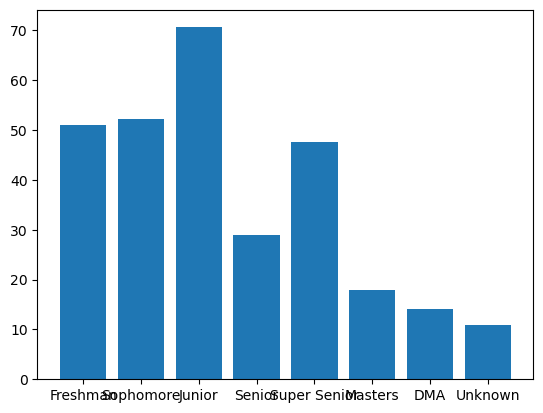

In [23]:
entries_by_grade
plt.bar(entries_by_grade.index, entries_by_grade["avg"])
plt.show()